# Data Exploration and Preprocessing

This notebook serves the below purposes:
- Data exploration and preprocessing for COCO-Text dataset.
- Data exploration on self-collected library books dataset.

# *Exploration on COCO-Text Dataset*

The COCO-Text annotations (COCO_Text.json) and the API tool were downloaded from https://vision.cornell.edu/se3/coco-text-2/#download .  COCO-Text does not provide any image.  All images come from MS COCO dataset.  COCO-Text annotation file only contains file information of the referenced images in MS COCO, and the bounding box information for each selected image with texts.  COCO-Text annotation 2017 v1.4 is referencing images from MS COCO 2014, which can be downloaded from http://cocodataset.org/#download

The follow sections try to achieve the below:
- Load the COCO-Text annotations and explore the statistics.
- Filter out file information and annotations with legible and machine printed texts.
- Copy the referenced images from MS COCO 2014, and build up the folder structures to prepare for training.
- Convert the annotations from COCO-Text format to Pascal VOC xml format to prepare for training.
- Validate the converted annotation files.
- Summarize COCO-Text annotations.

## Importing and Loading the COCO-Text Annotations

In [136]:
import sys
sys.path.append('../..')

from packages.cocotext import coco_text
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
from lxml import etree as et
import sys
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, PathPatch
import glob
from collections import Counter
%matplotlib inline

In [2]:
ct = coco_text.COCO_Text('../../data/cocotext/COCO_Text.json')

loading annotations into memory...
0:00:01.036999
creating index...
index created!


## Basic Statistics of COCO-Text

In [9]:
total_imgs = len(ct.imgs)
total_train = len(ct.train)
total_val = len(ct.val)
total_test = len(ct.test)
print('Total number of training images: {}\nTotal number of validation images: {}\nTotal number of test images: {}'
     .format(total_train, total_val, total_test))
print('Total number of images: {}'.format(total_imgs))

Total number of training images: 43686
Total number of validation images: 10000
Total number of test images: 10000
Total number of images: 63686


## Filter out images with legible and machine printed texts only.

In [10]:
imgs_train_legible_printed = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
imgs_val_legible_printed = ct.getImgIds(imgIds=ct.val, 
                    catIds=[('legibility','legible'),('class','machine printed')])
imgs_test_legible_printed = ct.getImgIds(imgIds=ct.test, 
                    catIds=[('legibility','legible'),('class','machine printed')])

total_train_legible_printed = len(imgs_train_legible_printed)
total_train_others = total_train - total_train_legible_printed

total_val_legible_printed = len(imgs_val_legible_printed)
total_val_others = total_val - total_val_legible_printed

total_test_legible_printed = len(imgs_test_legible_printed)
total_test_others = total_test - total_test_legible_printed

df_ct = pd.DataFrame({'Train': [total_train_legible_printed, total_train_others],
                     'Validation': [total_val_legible_printed, total_val_others],
                      'Test': [total_test_legible_printed, total_test_others]}, 
                     index = ['Legible & Printed', 'Others'])

display(df_ct)


,Train,Validation,Test
Legible & Printed,14324,3346,0
Others,29362,6654,10000


## Copying Images from MS COCO

In [13]:
src_dir='/home/haijie/machine-learning/temp/usb-ml/datasets/COCO/images/train2014/'
dst_dir='/home/haijie/machine-learning/temp/usb-ml/datasets/COCOText/2017/images/'

image_copy_error = {'train':[], 'val':[], 'test':[]}

def copy_coco_images(imgIDs, imgType):
    imgs = ct.loadImgs(imgIDs)
    for img in tqdm(imgs):
        file_name = img['file_name']
        src_path = src_dir + file_name
        dst_path = dst_dir + imgType + '/' + file_name
        try:
            shutil.copyfile(src_path, dst_path)
        except Exception as e:
            print('Error when copying file [', file_name, ': ', e)
            image_copy_error[imgType].append((file_name,e))
            
        

In [53]:
# Copy test images to 'test' folder
print('Copying test images...')
copy_coco_images(ct.test, 'test')
# Copy validation images to 'val' folder
print('Copying validation images...')
copy_coco_images(ct.val, 'val')
# Copy train images to 'train' folder
print('Copying train images...')
copy_coco_images(ct.train, 'train')


  0%|          | 0/10000 [00:00<?, ?it/s]

Copying test images...


  0%|          | 1/10000 [00:00<20:30,  8.12it/s]

Copying validation images...


  0%|          | 3/43686 [00:00<26:05, 27.90it/s]

Copying train images...


100%|██████████| 43686/43686 [29:40<00:00, 24.53it/s]


## Generate Pascal VOC Annotation XML File for Each Image

Sample of COCO-Text annotation format:
```json
{"imgs": {
    "378466": {
        "width": 612, 
        "file_name": "COCO_train2014_000000378466.jpg", 
        "set": "train", 
        "id": 378466, 
        "height": 612
        },
    ...
    },
"anns": {
    "1231468": {
        "polygon": [
            380.57979575247066,
            581.7662670169573,
            415.1992437528803,
            581.7662670169573,
            415.1992437528803,
            610.5664198710294,
            380.57979575247066,
            610.5664198710294
        ],
        "language": "english",
        "area": 997.0453941354001,
        "id": 1231468,
        "utf8_string": "BUSM",
        "image_id": 10581,
        "bbox": [
            380.57979575247066,
            581.7662670169573,
            34.61944800040967,
            28.800152854072127
        ],
        "legibility": "legible",
        "class": "machine printed"
        },
    ...
    },
}
```

Sample of Pascal VOC xml annotation:
```xml
<annotation>
  <folder>val</folder>
  <filename>COCO_train2014_000000000036.jpg</filename>
  <path>val/COCO_train2014_000000000036.jpg</path>
  <source>
    <database>Unknown</database>
  </source>
  <size>
    <width>481</width>
    <height>640</height>
    <depth>3</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>text</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>431</xmin>
      <ymin>181</ymin>
      <xmax>452</xmax>
      <ymax>215</ymax>
    </bndbox>
  </object>
  <object>
    <name>text</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>461</xmin>
      <ymin>180</ymin>
      <xmax>480</xmax>
      <ymax>215</ymax>
    </bndbox>
  </object>
</annotation>
```

In [15]:
annotation_dir = '/home/haijie/machine-learning/temp/usb-ml/datasets/COCOText/2017/annotations/'
object_class = 'text'

annotation_error = {'train':[], 'val':[], 'test':[]}

def generate_voc_from_cocotext(imgIDs, imgType, rootDir):
    for imgID in tqdm(imgIDs):
        try:
            img = ct.loadImgs(imgID)[0]
            # only generate annotations for legible printed text instances
            annIDs = ct.getAnnIds(imgID, catIds=[('legibility','legible'),('class','machine printed')])
            anns = ct.loadAnns(annIDs)
            tree = generate_voc_tree(img, anns, imgType)
            
            # Write the element tree to xml file
            ann_file_name = img['file_name'].split('.')[0] + '.xml'
            ann_file_path = rootDir + imgType + '/' + ann_file_name
            write_xml_file(tree, ann_file_path)
        except Exception as e:
            print('Error when generating annotation for [', str(imgID), ']: ', e)
            annotation_error[imgType].append((imgID, e))

def generate_voc_tree(img, anns, imgType):
    # Generate basic image info
    root = generate_voc_info(img, imgType)
    # Add bounding box information for each object instance
    if anns is not None and len(anns) > 0:
        for ann in anns:
            add_voc_object(ann, root)
    
    return root.getroottree()

def generate_voc_info(img, imgType):
    # root
    root = et.Element('annotation')
    # folder
    folder = et.SubElement(root, 'folder')
    folder.text = imgType
    # filename
    file_name = img['file_name']
    filename = et.SubElement(root,'filename')
    filename.text = file_name
    # path
    path = et.SubElement(root, 'path')
    path.text = imgType + '/' + file_name
    # source
    source = et.SubElement(root, 'source')
    database = et.SubElement(source, 'database')
    database.text = 'Unknown'
    # size
    size = et.SubElement(root, 'size')
    width = et.SubElement(size, 'width')
    width.text = str(img['width'])
    height = et.SubElement(size, 'height')
    height.text = str(img['height'])
    depth = et.SubElement(size, 'depth')
    depth.text = '3'
    # segmented
    segmented = et.SubElement(root, 'segmented')
    segmented.text = '0'
    
    return root

def add_voc_object(ann, root):
    # object
    obj = et.SubElement(root, 'object')
    # name
    name = et.SubElement(obj, 'name')
    name.text = object_class
    # pose
    pose = et.SubElement(obj, 'pose')
    pose.text = 'Unspecified'
    # truncated
    # TODO: consider enhancement
    truncated = et.SubElement(obj, 'truncated')
    truncated.text = '0'
    # difficult
    difficult = et.SubElement(obj, 'difficult')
    difficult.text = '0'
    # bndbox
    left = ann['bbox'][0]
    top = ann['bbox'][1]
    width = ann['bbox'][2]
    height = ann['bbox'][3]
    right = left + width
    bottom = top + height
    bndbox = et.SubElement(obj, 'bndbox')
    xmin = et.SubElement(bndbox, 'xmin')
    xmin.text = str(round(left))
    ymin = et.SubElement(bndbox, 'ymin')
    ymin.text = str(round(top))
    xmax = et.SubElement(bndbox, 'xmax')
    xmax.text = str(round(right)) 
    ymax = et.SubElement(bndbox, 'ymax')
    ymax.text = str(round(bottom))
    
def write_xml_file(tree, path):
    tree.write(path, pretty_print=True)



In [69]:
print('Generating annotations for validation set...')
sys.stdout.flush()
generate_voc_from_cocotext(ct.val, 'val', annotation_dir)

print('Generating annotations for training set...')
sys.stdout.flush()
generate_voc_from_cocotext(ct.train, 'train', annotation_dir)

Generating annotations for validation set...


100%|██████████| 10000/10000 [12:49<00:00, 12.99it/s]

Generating annotations for training set...



100%|██████████| 43686/43686 [56:04<00:00, 12.99it/s]


## Validate Images and Pascal VOC Annotations

In [44]:
def visualize_voc_annotation(img_file_name, img_dir, ann_dir):
    img_file_path = os.path.join(img_dir, img_file_name)
    ann_file_path = os.path.join(ann_dir, img_file_name.split('.')[0] + '.xml')

    # Load and display image
    img = cv2.imread(img_file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    show_voc_bbox(ann_file_path)
    
def show_voc_bbox(ann_file_path):
    tree = et.parse(ann_file_path)
    boxes = []
    colors = []
    for obj in tree.iter('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        width = xmax - xmin
        height = ymax - ymin
        print(xmin, ymin, width, height)
        boxes.append(Rectangle([xmin,ymin],width,height)) #,alpha=0.4))
        colors.append(np.random.random((1,3))[0])
    
    #collection = PatchCollection(boxes, facecolors=colors, edgecolors=(0,0,0,1), linewidths=3, alpha=0.4)
    collection = PatchCollection(boxes, facecolors='none', edgecolors='yellow', linewidths=2)
    ax = plt.gca()
    ax.add_collection(collection)
        

{'width': 480, 'file_name': 'COCO_train2014_000000573700.jpg', 'set': 'train', 'id': 573700, 'height': 640}
26
196 199 28 12
154 559 69 21
15 279 52 29
84 191 26 30
146 193 36 28
307 315 33 17
151 230 44 16
91 236 32 18
224 196 22 11
460 264 19 45
296 197 46 20
306 177 23 16
429 284 19 44
443 277 18 41
263 186 9 12
203 230 39 16
246 229 20 8
221 196 28 15
228 209 15 12
221 197 29 14
243 236 26 9
198 188 16 10
245 209 24 13
242 186 17 11
219 187 17 11
252 197 15 11


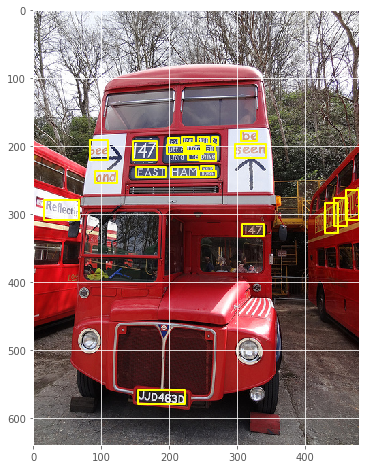

In [107]:
# Select a random image from COCO-Text annotation
test_imgid = 573700 #np.random.choice(imgs_train_legible_printed) #262124, 87083
test_img = ct.loadImgs([test_imgid])[0]
print(test_img)
test_img_file = test_img['file_name']
test_ann_ids = ct.getAnnIds(test_imgid, catIds=[('legibility','legible'),('class','machine printed')])
test_anns = ct.loadAnns(test_ann_ids)
print(len(test_anns))

img_dir = os.path.join(dst_dir, 'train')
ann_dir = os.path.join(annotation_dir, 'train')
visualize_voc_annotation(test_img_file, img_dir, ann_dir)

## Summarize COCO-Text Annotations

In [147]:
# Functions to summarize COCO-Text annotations
def summarize_annotations(annotation_dir):
    ann_summary = {'filenames':[], 'obj_counts':[], 'widths':[], 'heights':[]}
    ann_file_paths = glob.glob(os.path.join(annotation_dir, '*.xml'))
    for ann_file_path in ann_file_paths:
        tree = et.parse(ann_file_path)
        root = tree.getroot()
        filename = root.find('filename').text
        obj_count = len(root.findall('object'))
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        ann_summary['filenames'].append(filename)
        ann_summary['obj_counts'].append(obj_count)
        ann_summary['widths'].append(width)
        ann_summary['heights'].append(height)
    
    return ann_summary

def display_annotation_summary(ann_summary):
    obj_counts = np.array(ann_summary['obj_counts'])
    # filter out those without text
    obj_counts = obj_counts[obj_counts>0]
    
    n_objs = sum(obj_counts)
    obj_min = min(obj_counts)
    obj_max = max(obj_counts)
    obj_mean = np.mean(obj_counts)
    width_min = min(ann_summary['widths'])
    width_max = max(ann_summary['widths'])
    width_mean = np.mean(ann_summary['widths'])
    height_min = min(ann_summary['heights'])
    height_max = max(ann_summary['heights'])
    height_mean = np.mean(ann_summary['heights'])
    
    print('Text instances: total - {}, min - {}, max - {}, mean - {}'.format(n_objs, obj_min, obj_max, obj_mean))
    print('Width: min - {}, max - {}, mean - {}'.format(width_min, width_max, width_mean))
    print('Height: min - {}, max - {}, mean - {}'.format(height_min, height_max, height_mean))
    
def visualize_object_counts(ann_summary, title):
    obj_counts = np.array(ann_summary['obj_counts'])
    obj_counts = obj_counts[obj_counts>0]
    
    # get frequncy dictionary
    freq = Counter(obj_counts)
    keys = np.array(list(freq.keys()))  # number of text instances per image
    values = np.array(list(freq.values()))  # number of images with the respective instance count
    # remove outliers
    #keys = keys[values > 4]
    #values = values[values > 4]

    plt.bar(keys, values)
    plt.title(title)
    plt.xlabel('Text Instance Count')
    plt.ylabel('Number of images')
    

In [139]:
ann_summary_train = summarize_annotations(os.path.join(annotation_dir, 'train'))
ann_summary_val = summarize_annotations(os.path.join(annotation_dir, 'val'))

Training set summary:
Text instances: total - 65720, min - 1, max - 209, mean - 4.588103881597319
Width: min - 120, max - 640, mean - 578.3173785652154
Height: min - 102, max - 640, mean - 483.79460238978163

Validation set summary:
Text instances: total - 15127, min - 1, max - 60, mean - 4.52092050209205
Width: min - 72, max - 640, mean - 578.0374
Height: min - 51, max - 640, mean - 482.6475


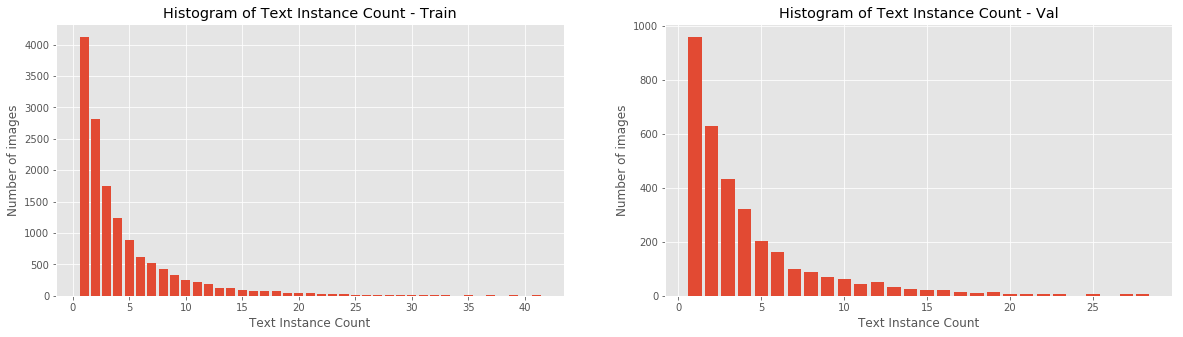

In [144]:
plt.style.use('ggplot')
print('Training set summary:')
display_annotation_summary(ann_summary_train)
print('\nValidation set summary:')
display_annotation_summary(ann_summary_val)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
visualize_object_counts(ann_summary_train, 'Histogram of Text Instance Count - Train')
plt.subplot(1,2,2)
visualize_object_counts(ann_summary_val, 'Histogram of Text Instance Count - Val')
plt.show()


# *Data Exploration on Library Books Dataset*

## Summarize Library Books Annotations

In [149]:
annotation_dir = '../../data/librarybooks/annotations'
ann_summary_train = summarize_annotations(os.path.join(annotation_dir, 'train'))
ann_summary_val = summarize_annotations(os.path.join(annotation_dir, 'val'))
ann_summary_test = summarize_annotations(os.path.join(annotation_dir, 'test'))

Training set summary:
Text instances: total - 571, min - 3, max - 11, mean - 5.947916666666667
Width: min - 816, max - 816, mean - 816.0
Height: min - 612, max - 612, mean - 612.0

Validation set summary:
Text instances: total - 86, min - 4, max - 7, mean - 5.375
Width: min - 816, max - 816, mean - 816.0
Height: min - 612, max - 612, mean - 612.0

Test set summary:
Text instances: total - 88, min - 4, max - 8, mean - 5.5
Width: min - 816, max - 816, mean - 816.0
Height: min - 612, max - 612, mean - 612.0


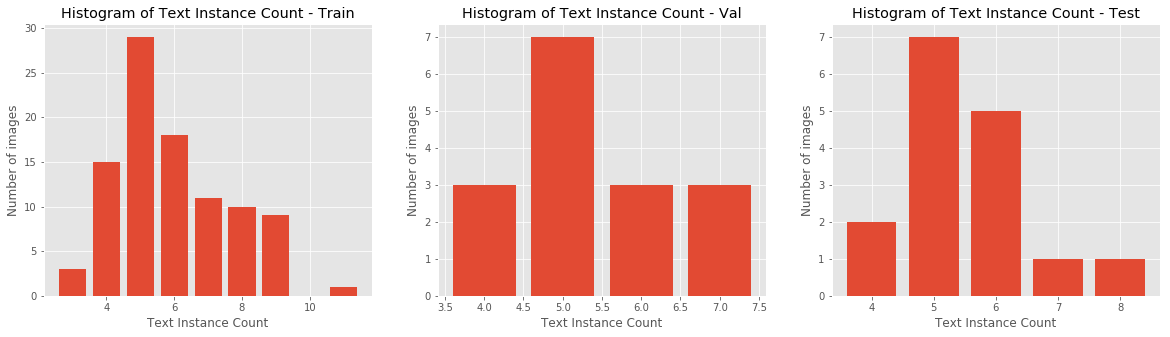

In [151]:
print('Training set summary:')
display_annotation_summary(ann_summary_train)
print('\nValidation set summary:')
display_annotation_summary(ann_summary_val)
print('\nTest set summary:')
display_annotation_summary(ann_summary_test)

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
visualize_object_counts(ann_summary_train, 'Histogram of Text Instance Count - Train')
plt.subplot(1,3,2)
visualize_object_counts(ann_summary_val, 'Histogram of Text Instance Count - Val')
plt.subplot(1,3,3)
visualize_object_counts(ann_summary_test, 'Histogram of Text Instance Count - Test')
plt.show()
#plt.tight_layout()